sources:

https://graphframes.github.io/graphframes/docs/_site/user-guide.html

https://docs.databricks.com/_static/notebooks/graphframes-user-guide-py.html

https://towardsdatascience.com/graphframes-in-jupyter-a-practical-guide-9b3b346cebc5

https://graphframes.github.io/graphframes/docs/_site/api/python/index.html

https://github.com/haoyingyang/SN/blob/master/Network_Final.ipynb

In [1]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

import findspark
findspark.init()

from pyspark import *
from pyspark.sql import *
from graphframes import *

In [2]:
# https://graphframes.github.io/graphframes/docs/_site/quick-start.html
# https://stackoverflow.com/questions/65011599/how-to-start-graphframes-on-spark-on-pyspark-on-juypter-on-docker
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages graphframes:graphframes:0.8.1-spark3.0-s_2.12 pyspark-shell'

In [3]:
# Start Spark context
spark = SparkSession.builder.appName('graphx-network-analysis').getOrCreate()

21/10/21 10:08:35 WARN Utils: Your hostname, mark-machine resolves to a loopback address: 127.0.1.1; using 192.168.50.16 instead (on interface wlp8s0)
21/10/21 10:08:35 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


:: loading settings :: url = jar:file:/opt/spark/jars/ivy-2.4.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/mark/.ivy2/cache
The jars for the packages stored in: /home/mark/.ivy2/jars
graphframes#graphframes added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-386f0c33-8b65-4649-9749-52cecafc7e41;1.0
	confs: [default]
	found graphframes#graphframes;0.8.1-spark3.0-s_2.12 in spark-packages
	found org.slf4j#slf4j-api;1.7.16 in central
:: resolution report :: resolve 163ms :: artifacts dl 4ms
	:: modules in use:
	graphframes#graphframes;0.8.1-spark3.0-s_2.12 from spark-packages in [default]
	org.slf4j#slf4j-api;1.7.16 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   2   |   0   |   0   |   0   ||   2   |   0   |
	-------------------------------------

In [4]:
%%bash
file=./data/amazon0302.txt.gz
file_meta=./data/amazon-meta.txt.gz

if [ -e "$file" ]; then
    echo "$file exists, skipping"
else 
    echo "$file does not exist, using wget to download it"
    wget http://snap.stanford.edu/data/amazon0302.txt.gz -P data/
    gzip -dkfv $file
fi

if [ -e "$file_meta" ]; then
    echo "$file_meta exists, skipping"
else 
    echo "$file_meta does not exist, using wget to download it"
    wget http://snap.stanford.edu/data/amazon0302.txt.gz -P data/
    gzip -dkfv $file_meta
fi

./data/amazon0302.txt.gz exists, skipping
./data/amazon-meta.txt.gz exists, skipping


In [5]:
def read_data(from_file_name, exclude_meta=True):
    df_edges = pd.read_csv(from_file_name, sep="\t", header=None, skiprows=4, names=["src", "dst"])
    vertices_np = \
        np.unique(np.hstack([df_edges["src"].unique(), df_edges["dst"].unique()]))
    
    df_vertices = pd.DataFrame(data={"id": vertices_np})
    
    meta_cols = ["ansi", "title", "group", "salesrank", "similar", "categories", "reviews"]
    
    if exclude_meta:
        df_vertices[meta_cols] = np.nan
    else:
        # read meta file and construct column values
        # until then same as no meta
        df_vertices[meta_cols] = np.nan

    
    return df_edges, df_vertices
    
from_file_name = "data/amazon0302.txt"
df_edges, df_vertices = read_data(from_file_name=from_file_name)

In [14]:
def read_meta(from_file_name):
    cols = ["title", "group", "salesrank", "similar", "categories", "reviews"]
    
    discontinued_prodcut_str = "discontinued product"
    
    from_file_name = "data/amazon-meta.txt"
    
    with open(from_file_name, "r") as file:
        lines = file.readlines()[2:100]
        print(lines)
        
        lines = lines[:100]
        length = len(lines)
        idx = 0
        
        while idx < length:
            line = lines[idx]
            print("idx")
            print(idx)
            print("line")
            print(line)
            
            try:
                if_discontinued_str = lines[idx+3].strip()
            
                if if_discontinued_str == discontinued_prodcut_str:
                    print(f"if_discontinued_str at {idx+3}")
                    del lines[0]
                    del lines[0]
                    del lines[0]
                    del lines[0]
                else:
                    idx += 1
            except Exception:
                return
            else:
                pass
            
                
            
        
        
from_file_name = "data/amazon-meta.txt"
read_meta(from_file_name=from_file_name)

['\n', 'Id:   0\n', 'ASIN: 0771044445\n', '  discontinued product\n', '\n', 'Id:   1\n', 'ASIN: 0827229534\n', '  title: Patterns of Preaching: A Sermon Sampler\n', '  group: Book\n', '  salesrank: 396585\n', '  similar: 5  0804215715  156101074X  0687023955  0687074231  082721619X\n', '  categories: 2\n', '   |Books[283155]|Subjects[1000]|Religion & Spirituality[22]|Christianity[12290]|Clergy[12360]|Preaching[12368]\n', '   |Books[283155]|Subjects[1000]|Religion & Spirituality[22]|Christianity[12290]|Clergy[12360]|Sermons[12370]\n', '  reviews: total: 2  downloaded: 2  avg rating: 5\n', '    2000-7-28  cutomer: A2JW67OY8U6HHK  rating: 5  votes:  10  helpful:   9\n', '    2003-12-14  cutomer: A2VE83MZF98ITY  rating: 5  votes:   6  helpful:   5\n', '\n', 'Id:   2\n', 'ASIN: 0738700797\n', '  title: Candlemas: Feast of Flames\n', '  group: Book\n', '  salesrank: 168596\n', '  similar: 5  0738700827  1567184960  1567182836  0738700525  0738700940\n', '  categories: 2\n', '   |Books[283155

In [24]:
from dgl.data import CoraGraphDataset, AmazonCoBuyComputerDataset

def load_cora_data():
    dataset = CoraGraphDataset()
    g = dataset[0]
    features = g.ndata['feat']
    labels = g.ndata['label']
    train_mask = g.ndata['train_mask']
    test_mask = g.ndata['test_mask']
    return g, features, labels, train_mask, test_mask

def load_amazon_data():
    dataset = AmazonCoBuyComputerDataset()
    g = dataset[0]
    features = g.ndata['feat']
    labels = g.ndata['label']
    
    return g, features, labels


g, features, labels = load_amazon_data()

In [49]:
src = g.edges()[0].cpu().detach().numpy()
dst = g.edges()[1].cpu().detach().numpy()
print(labels.shape)
print(dst.shape)

torch.Size([13752])
(491722,)


In [54]:
df_edges_2 = pd.DataFrame(data={"src":src, "dst":dst})
print(df_edges_2)

df_vertices_2 = pd.DataFrame(data={"id":range(labels.shape[0]), "labels":labels})
print(df_vertices_2)

vertices = spark.createDataFrame(df_vertices_2, list(df_vertices_2.columns.values))
edges = spark.createDataFrame(df_edges_2, list(df_edges_2.columns.values))
g = GraphFrame(vertices, edges)

          src    dst
0           1      0
1           2      0
2           3      0
3           0      1
4           2      1
...       ...    ...
491717  13466  13469
491718  13465  13469
491719  13468  13469
491720  13470  13469
491721  13469  13470

[491722 rows x 2 columns]
          id  labels
0          0       8
1          1       8
2          2       1
3          3       8
4          4       4
...      ...     ...
13747  13747       4
13748  13748       4
13749  13749       4
13750  13750       8
13751  13751       4

[13752 rows x 2 columns]


In [55]:
g.vertices.show()
g.edges.show()

+---+------+
| id|labels|
+---+------+
|  0|     8|
|  1|     8|
|  2|     1|
|  3|     8|
|  4|     4|
|  5|     4|
|  6|     4|
|  7|     8|
|  8|     8|
|  9|     8|
| 10|     8|
| 11|     3|
| 12|     3|
| 13|     4|
| 14|     4|
| 15|     4|
| 16|     7|
| 17|     7|
| 18|     7|
| 19|     3|
+---+------+
only showing top 20 rows

+---+---+
|src|dst|
+---+---+
|  1|  0|
|  2|  0|
|  3|  0|
|  0|  1|
|  2|  1|
|  3|  1|
|  0|  2|
|  1|  2|
|  3|  2|
|  0|  3|
|  1|  3|
|  2|  3|
|  6|  4|
|  5|  4|
|  6|  5|
|  4|  5|
|  5|  6|
|  4|  6|
|  9|  7|
|  8|  7|
+---+---+
only showing top 20 rows



In [6]:
print(df_edges)
print(df_vertices)

            src     dst
0             0       1
1             0       2
2             0       3
3             0       4
4             0       5
...         ...     ...
1234872  262110  262099
1234873  262110  262100
1234874  262110  262101
1234875  262110  262106
1234876  262110  262107

[1234877 rows x 2 columns]
            id  ansi  title  group  salesrank  similar  categories  reviews
0            0   NaN    NaN    NaN        NaN      NaN         NaN      NaN
1            1   NaN    NaN    NaN        NaN      NaN         NaN      NaN
2            2   NaN    NaN    NaN        NaN      NaN         NaN      NaN
3            3   NaN    NaN    NaN        NaN      NaN         NaN      NaN
4            4   NaN    NaN    NaN        NaN      NaN         NaN      NaN
...        ...   ...    ...    ...        ...      ...         ...      ...
262106  262106   NaN    NaN    NaN        NaN      NaN         NaN      NaN
262107  262107   NaN    NaN    NaN        NaN      NaN         NaN      NaN


In [7]:
vertices = spark.createDataFrame(df_vertices, list(df_vertices.columns.values))
edges = spark.createDataFrame(df_edges, list(df_edges.columns.values))
g = GraphFrame(vertices, edges)

In [8]:
g.vertices.show()
g.edges.show()

21/10/20 21:40:28 WARN TaskSetManager: Stage 0 contains a task of very large size (2213 KiB). The maximum recommended task size is 1000 KiB.
21/10/20 21:40:29 WARN TaskSetManager: Stage 1 contains a task of very large size (1204 KiB). The maximum recommended task size is 1000 KiB.


+---+----+-----+-----+---------+-------+----------+-------+
| id|ansi|title|group|salesrank|similar|categories|reviews|
+---+----+-----+-----+---------+-------+----------+-------+
|  0| NaN|  NaN|  NaN|      NaN|    NaN|       NaN|    NaN|
|  1| NaN|  NaN|  NaN|      NaN|    NaN|       NaN|    NaN|
|  2| NaN|  NaN|  NaN|      NaN|    NaN|       NaN|    NaN|
|  3| NaN|  NaN|  NaN|      NaN|    NaN|       NaN|    NaN|
|  4| NaN|  NaN|  NaN|      NaN|    NaN|       NaN|    NaN|
|  5| NaN|  NaN|  NaN|      NaN|    NaN|       NaN|    NaN|
|  6| NaN|  NaN|  NaN|      NaN|    NaN|       NaN|    NaN|
|  7| NaN|  NaN|  NaN|      NaN|    NaN|       NaN|    NaN|
|  8| NaN|  NaN|  NaN|      NaN|    NaN|       NaN|    NaN|
|  9| NaN|  NaN|  NaN|      NaN|    NaN|       NaN|    NaN|
| 10| NaN|  NaN|  NaN|      NaN|    NaN|       NaN|    NaN|
| 11| NaN|  NaN|  NaN|      NaN|    NaN|       NaN|    NaN|
| 12| NaN|  NaN|  NaN|      NaN|    NaN|       NaN|    NaN|
| 13| NaN|  NaN|  NaN|      NaN|    NaN|

In [9]:
print((g.vertices.count(), len(g.vertices.columns)))
print((g.edges.count(), len(g.edges.columns)))

21/10/20 21:40:29 WARN TaskSetManager: Stage 2 contains a task of very large size (2213 KiB). The maximum recommended task size is 1000 KiB.


(262111, 8)


21/10/20 21:40:30 WARN TaskSetManager: Stage 4 contains a task of very large size (1204 KiB). The maximum recommended task size is 1000 KiB.


(1234877, 2)


In [10]:
g.degrees.show()
g.inDegrees.show()
g.outDegrees.show()

21/10/20 21:40:31 WARN TaskSetManager: Stage 6 contains a task of very large size (1204 KiB). The maximum recommended task size is 1000 KiB.
21/10/20 21:40:32 WARN TaskSetManager: Stage 8 contains a task of very large size (1204 KiB). The maximum recommended task size is 1000 KiB.


+----+------+
|  id|degree|
+----+------+
|  26|    17|
|  29|    45|
| 474|     4|
|1677|    13|
|1697|     7|
| 964|    13|
|1806|    18|
|1950|     9|
|2453|     8|
|3091|     8|
|2040|     6|
|3506|    15|
|2214|    24|
|2250|     9|
|5385|     9|
|7225|    13|
|2509|     6|
|5409|    14|
|2529|    18|
|2927|     7|
+----+------+
only showing top 20 rows



+----+--------+
|  id|inDegree|
+----+--------+
|  26|      12|
|  29|      40|
| 474|       4|
|1677|       8|
|1697|       2|
| 964|       8|
|1806|      13|
|1950|       4|
|2453|       3|
|3091|       3|
|2040|       1|
|3506|      10|
|2214|      19|
|2250|       4|
|5385|       4|
|7225|       8|
|2509|       1|
|5409|       9|
|2529|      13|
|2927|       2|
+----+--------+
only showing top 20 rows



21/10/20 21:40:33 WARN TaskSetManager: Stage 10 contains a task of very large size (1204 KiB). The maximum recommended task size is 1000 KiB.


+----+---------+
|  id|outDegree|
+----+---------+
|  26|        5|
|  29|        5|
| 964|        5|
|1677|        5|
|1697|        5|
|1806|        5|
|1950|        5|
|2040|        5|
|2214|        5|
|2250|        5|
|2453|        5|
|2509|        5|
|2529|        5|
|2927|        5|
|3091|        5|
|3506|        5|
|3764|        5|
|4590|        5|
|4823|        5|
|4894|        5|
+----+---------+
only showing top 20 rows



21/10/20 21:40:33 WARN TaskSetManager: Stage 12 contains a task of very large size (1204 KiB). The maximum recommended task size is 1000 KiB.


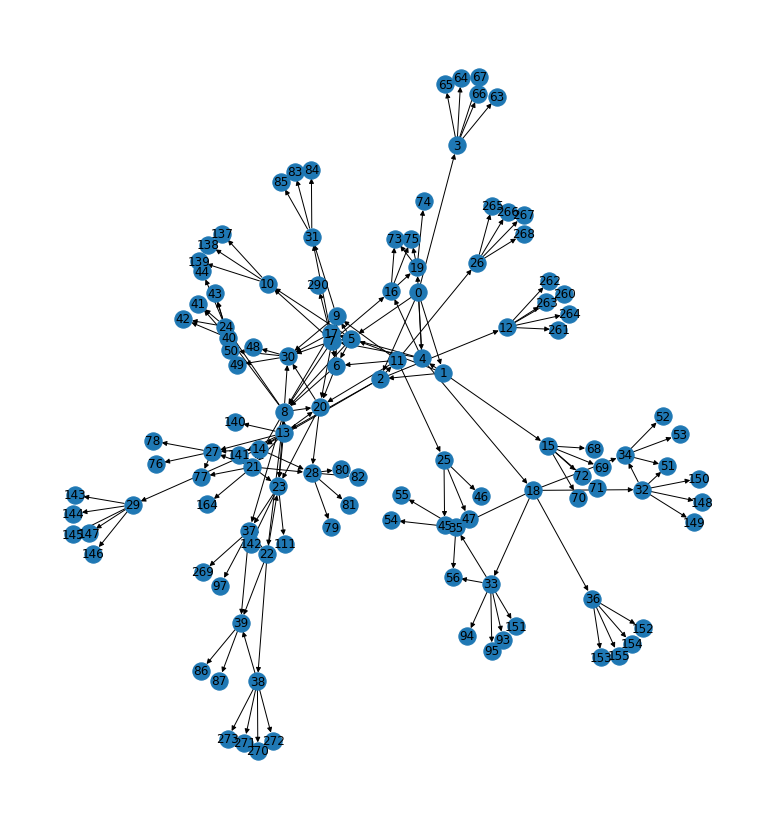

In [11]:
def plot_graph(edges, take_n=300):
    Gplot=nx.Graph()
    for row in edges.select("src", "dst").take(take_n):
        Gplot.add_edge(row["src"],row["dst"])

    plt.figure(figsize=(30,15))
    plt.subplot(121)
    nx.draw(Gplot, with_labels=True, arrows=True)

plot_graph(g.edges, take_n=200)

In [12]:
g.degrees.show()

21/10/20 21:40:35 WARN TaskSetManager: Stage 13 contains a task of very large size (1204 KiB). The maximum recommended task size is 1000 KiB.


+----+------+
|  id|degree|
+----+------+
|  26|    17|
|  29|    45|
| 474|     4|
|1677|    13|
|1697|     7|
| 964|    13|
|1806|    18|
|1950|     9|
|2453|     8|
|3091|     8|
|2040|     6|
|3506|    15|
|2214|    24|
|2250|     9|
|5385|     9|
|7225|    13|
|2509|     6|
|5409|    14|
|2529|    18|
|2927|     7|
+----+------+
only showing top 20 rows



In [13]:
from pyspark.sql.functions import desc

g.degrees.sort(desc("degree")).show()
g.degrees.sort(desc("degree")).show()

21/10/20 21:40:36 WARN TaskSetManager: Stage 15 contains a task of very large size (1204 KiB). The maximum recommended task size is 1000 KiB.
21/10/20 21:40:37 WARN TaskSetManager: Stage 17 contains a task of very large size (1204 KiB). The maximum recommended task size is 1000 KiB.


+-----+------+
|   id|degree|
+-----+------+
|14949|   425|
| 4429|   409|
|   33|   366|
|10519|   339|
|12771|   335|
|    8|   298|
|  297|   280|
|  481|   280|
| 5737|   277|
| 9106|   232|
| 8939|   226|
|   93|   224|
| 1241|   223|
| 5765|   214|
| 2501|   196|
|   99|   193|
| 3661|   186|
| 2353|   184|
|  244|   184|
|17525|   180|
+-----+------+
only showing top 20 rows



+-----+------+
|   id|degree|
+-----+------+
|14949|   425|
| 4429|   409|
|   33|   366|
|10519|   339|
|12771|   335|
|    8|   298|
|  297|   280|
|  481|   280|
| 5737|   277|
| 9106|   232|
| 8939|   226|
|   93|   224|
| 1241|   223|
| 5765|   214|
| 2501|   196|
|   99|   193|
| 3661|   186|
| 2353|   184|
|  244|   184|
|17525|   180|
+-----+------+
only showing top 20 rows



In [69]:
degrees_df = \
    g.degrees.\
    join(g.inDegrees, g.degrees["id"] == g.inDegrees["id"], "outer").\
    join(g.outDegrees, g.degrees["id"] == g.outDegrees["id"], "outer").\
    drop(g.outDegrees.id).\
    drop(g.inDegrees.id).\
    na.fill(0)

degrees_df.sort(desc("degree")).show()

21/10/20 22:19:43 WARN TaskSetManager: Stage 1314 contains a task of very large size (1204 KiB). The maximum recommended task size is 1000 KiB.
21/10/20 22:19:44 WARN TaskSetManager: Stage 1315 contains a task of very large size (1204 KiB). The maximum recommended task size is 1000 KiB.
21/10/20 22:19:44 WARN TaskSetManager: Stage 1317 contains a task of very large size (1204 KiB). The maximum recommended task size is 1000 KiB.


+-----+------+--------+---------+
|   id|degree|inDegree|outDegree|
+-----+------+--------+---------+
|14949|   425|     420|        5|
| 4429|   409|     404|        5|
|   33|   366|     361|        5|
|10519|   339|     334|        5|
|12771|   335|     330|        5|
|    8|   298|     293|        5|
|  297|   280|     280|        0|
|  481|   280|     275|        5|
| 5737|   277|     272|        5|
| 9106|   232|     227|        5|
| 8939|   226|     221|        5|
|   93|   224|     219|        5|
| 1241|   223|     218|        5|
| 5765|   214|     209|        5|
| 2501|   196|     191|        5|
|   99|   193|     188|        5|
| 3661|   186|     181|        5|
|  244|   184|     179|        5|
| 2353|   184|     179|        5|
|17525|   180|     175|        5|
+-----+------+--------+---------+
only showing top 20 rows



In [70]:
degrees_list = [int(d.degree) for d in degrees_df.select('degree').collect()]
in_degree_list = [int(d.inDegree) for d in degrees_df.select('inDegree').collect()]
out_degree_list = [int(d.outDegree) for d in degrees_df.select('outDegree').collect()]

21/10/20 22:19:49 WARN TaskSetManager: Stage 1319 contains a task of very large size (1204 KiB). The maximum recommended task size is 1000 KiB.
21/10/20 22:19:49 WARN TaskSetManager: Stage 1320 contains a task of very large size (1204 KiB). The maximum recommended task size is 1000 KiB.
21/10/20 22:19:50 WARN TaskSetManager: Stage 1322 contains a task of very large size (1204 KiB). The maximum recommended task size is 1000 KiB.
21/10/20 22:19:52 WARN TaskSetManager: Stage 1324 contains a task of very large size (1204 KiB). The maximum recommended task size is 1000 KiB.
21/10/20 22:19:52 WARN TaskSetManager: Stage 1325 contains a task of very large size (1204 KiB). The maximum recommended task size is 1000 KiB.
21/10/20 22:19:53 WARN TaskSetManager: Stage 1327 contains a task of very large size (1204 KiB). The maximum recommended task size is 1000 KiB.
21/10/20 22:19:55 WARN TaskSetManager: Stage 1329 contains a task of very large size (1204 KiB). The maximum recommended task size is 10

In [87]:
def plot_n_nodes_vs_degree(x, n_bins, x_step, yscale, ylabel, xlabel, title, save_path=None):
    plt.figure(figsize=(10, 5))
    plt.hist(x, bins=n_bins)
    assert yscale in ["log", "linear"]
    plt.yscale(yscale)
    plt.grid("on")
    plt.xticks(np.arange(min(x)-1, max(x)+x_step, x_step))
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.title(title)
    
    if save_path is not None:
        plt.savefig(save_path)
    else:
        pass
    
    plt.show()

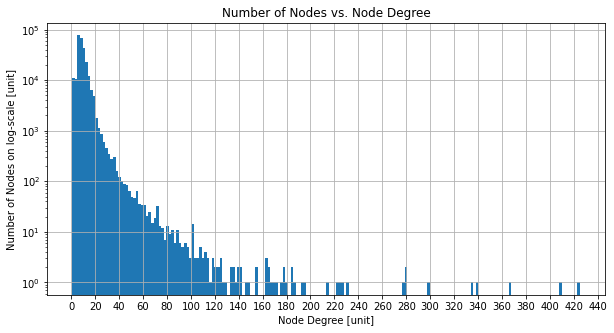

In [89]:
x = degrees_list
n_bins = 200
x_step = 20
yscale = "log"
ylabel = "Number of Nodes on log-scale [unit]"
xlabel = "Node Degree [unit]"
title = "Number of Nodes vs. Node Degree"
save_path = "assets/n_nodes_vs_degree.png"

plot_n_nodes_vs_degree(
    x=x, 
    n_bins=n_bins, 
    x_step=x_step,
    yscale=yscale,
    ylabel=ylabel, 
    xlabel=xlabel, 
    title=title, 
    save_path=save_path)

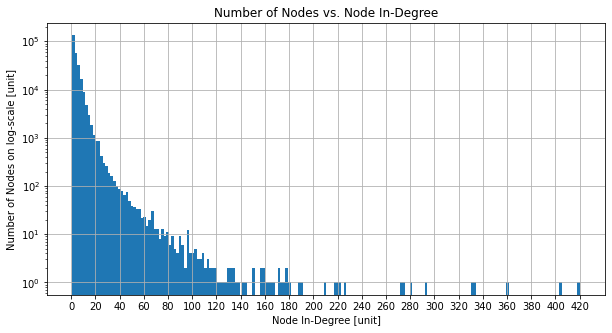

In [90]:
x = in_degree_list
n_bins = 200
x_step = 20
yscale = "log"
ylabel = "Number of Nodes on log-scale [unit]"
xlabel = "Node In-Degree [unit]"
title = "Number of Nodes vs. Node In-Degree"
save_path = "assets/n_nodes_vs_in_degree.png"

plot_n_nodes_vs_degree(
    x=x, 
    n_bins=n_bins, 
    x_step=x_step,
    yscale=yscale,
    ylabel=ylabel, 
    xlabel=xlabel, 
    title=title, 
    save_path=save_path)

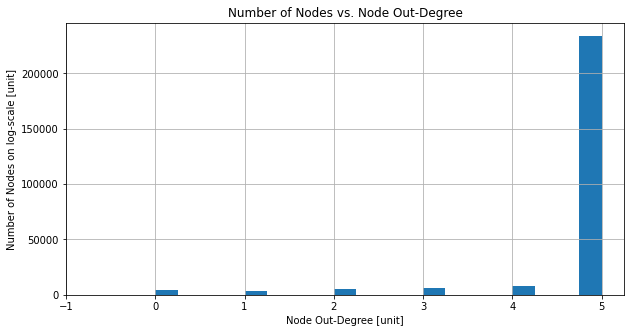

In [93]:
x = out_degree_list
n_bins = 20
x_step = 1
yscale = "linear"
ylabel = "Number of Nodes on log-scale [unit]"
xlabel = "Node Out-Degree [unit]"
title = "Number of Nodes vs. Node Out-Degree"
save_path = "assets/n_nodes_vs_out_degree.png"

plot_n_nodes_vs_degree(
    x=x, 
    n_bins=n_bins, 
    x_step=x_step,
    yscale=yscale,
    ylabel=ylabel, 
    xlabel=xlabel, 
    title=title, 
    save_path=save_path)

In [15]:
motifs = g.find("(a)-[e]->(b); (b)-[e2]->(a)")
motifs.show()

21/10/20 21:40:43 WARN TaskSetManager: Stage 24 contains a task of very large size (1204 KiB). The maximum recommended task size is 1000 KiB.
21/10/20 21:40:44 WARN TaskSetManager: Stage 25 contains a task of very large size (1204 KiB). The maximum recommended task size is 1000 KiB.
21/10/20 21:40:44 WARN TaskSetManager: Stage 26 contains a task of very large size (2213 KiB). The maximum recommended task size is 1000 KiB.
21/10/20 21:40:45 WARN TaskSetManager: Stage 28 contains a task of very large size (2213 KiB). The maximum recommended task size is 1000 KiB.


+--------------------+------------+--------------------+------------+
|                   a|           e|                   b|          e2|
+--------------------+------------+--------------------+------------+
|{19, NaN, NaN, Na...|     {19, 4}|{4, NaN, NaN, NaN...|     {4, 19}|
|{96, NaN, NaN, Na...|    {96, 56}|{56, NaN, NaN, Na...|    {56, 96}|
|{90, NaN, NaN, Na...|   {90, 172}|{172, NaN, NaN, N...|   {172, 90}|
|{198, NaN, NaN, N...|  {198, 232}|{232, NaN, NaN, N...|  {232, 198}|
|{266, NaN, NaN, N...|  {266, 267}|{267, NaN, NaN, N...|  {267, 266}|
|{1187, NaN, NaN, ...| {1187, 453}|{453, NaN, NaN, N...| {453, 1187}|
|{1690, NaN, NaN, ...| {1690, 511}|{511, NaN, NaN, N...| {511, 1690}|
|{166, NaN, NaN, N...|  {166, 619}|{619, NaN, NaN, N...|  {619, 166}|
|{560, NaN, NaN, N...|  {560, 814}|{814, NaN, NaN, N...|  {814, 560}|
|{1796, NaN, NaN, ...| {1796, 849}|{849, NaN, NaN, N...| {849, 1796}|
|{1385, NaN, NaN, ...| {1385, 953}|{953, NaN, NaN, N...| {953, 1385}|
|{2637, NaN, NaN, ..

In [16]:
# b is mutually copurchased with a and c
mutually_copurchased_products_df = g.find("(a)-[]->(mutual); (mutual)-[]->(c); (c)-[]->(mutual); (mutual)-[]->(a)").dropDuplicates()
mutually_copurchased_products_df.show()

21/10/20 21:40:51 WARN TaskSetManager: Stage 40 contains a task of very large size (1204 KiB). The maximum recommended task size is 1000 KiB.
21/10/20 21:40:51 WARN TaskSetManager: Stage 31 contains a task of very large size (1204 KiB). The maximum recommended task size is 1000 KiB.
21/10/20 21:40:52 WARN TaskSetManager: Stage 32 contains a task of very large size (2213 KiB). The maximum recommended task size is 1000 KiB.
21/10/20 21:40:52 WARN TaskSetManager: Stage 34 contains a task of very large size (2213 KiB). The maximum recommended task size is 1000 KiB.
21/10/20 21:40:55 WARN TaskSetManager: Stage 35 contains a task of very large size (1204 KiB). The maximum recommended task size is 1000 KiB.
21/10/20 21:40:55 WARN TaskSetManager: Stage 36 contains a task of very large size (2213 KiB). The maximum recommended task size is 1000 KiB.
21/10/20 21:40:59 WARN TaskSetManager: Stage 39 contains a task of very large size (1204 KiB). The maximum recommended task size is 1000 KiB.


+--------------------+--------------------+--------------------+
|                   a|              mutual|                   c|
+--------------------+--------------------+--------------------+
|{90, NaN, NaN, Na...|{172, NaN, NaN, N...|{173, NaN, NaN, N...|
|{3576, NaN, NaN, ...|{3579, NaN, NaN, ...|{3577, NaN, NaN, ...|
|{14283, NaN, NaN,...|{8522, NaN, NaN, ...|{14284, NaN, NaN,...|
|{10251, NaN, NaN,...|{10253, NaN, NaN,...|{14672, NaN, NaN,...|
|{15564, NaN, NaN,...|{15272, NaN, NaN,...|{9720, NaN, NaN, ...|
|{21344, NaN, NaN,...|{26545, NaN, NaN,...|{21344, NaN, NaN,...|
|{12945, NaN, NaN,...|{29991, NaN, NaN,...|{44186, NaN, NaN,...|
|{36725, NaN, NaN,...|{36723, NaN, NaN,...|{36724, NaN, NaN,...|
|{41900, NaN, NaN,...|{41898, NaN, NaN,...|{22791, NaN, NaN,...|
|{62582, NaN, NaN,...|{42039, NaN, NaN,...|{62584, NaN, NaN,...|
|{44889, NaN, NaN,...|{47156, NaN, NaN,...|{71599, NaN, NaN,...|
|{47944, NaN, NaN,...|{47946, NaN, NaN,...|{48812, NaN, NaN,...|
|{39450, NaN, NaN,...|{48

In [17]:
g.triangleCount().show()

21/10/20 21:41:14 WARN TaskSetManager: Stage 44 contains a task of very large size (2213 KiB). The maximum recommended task size is 1000 KiB.
21/10/20 21:41:15 WARN TaskSetManager: Stage 45 contains a task of very large size (1204 KiB). The maximum recommended task size is 1000 KiB.
21/10/20 21:41:16 WARN TaskSetManager: Stage 46 contains a task of very large size (2213 KiB). The maximum recommended task size is 1000 KiB.
21/10/20 21:41:16 WARN TaskSetManager: Stage 49 contains a task of very large size (2213 KiB). The maximum recommended task size is 1000 KiB.
21/10/20 21:41:22 WARN TaskSetManager: Stage 51 contains a task of very large size (2213 KiB). The maximum recommended task size is 1000 KiB.
21/10/20 21:41:25 WARN TaskSetManager: Stage 53 contains a task of very large size (1204 KiB). The maximum recommended task size is 1000 KiB.


+-----+----+----+-----+-----+---------+-------+----------+-------+
|count|  id|ansi|title|group|salesrank|similar|categories|reviews|
+-----+----+----+-----+-----+---------+-------+----------+-------+
|   19|  26| NaN|  NaN|  NaN|      NaN|    NaN|       NaN|    NaN|
|   48|  29| NaN|  NaN|  NaN|      NaN|    NaN|       NaN|    NaN|
|    0| 474| NaN|  NaN|  NaN|      NaN|    NaN|       NaN|    NaN|
|    2| 964| NaN|  NaN|  NaN|      NaN|    NaN|       NaN|    NaN|
|   17|1677| NaN|  NaN|  NaN|      NaN|    NaN|       NaN|    NaN|
|    1|1697| NaN|  NaN|  NaN|      NaN|    NaN|       NaN|    NaN|
|   24|1806| NaN|  NaN|  NaN|      NaN|    NaN|       NaN|    NaN|
|   10|1950| NaN|  NaN|  NaN|      NaN|    NaN|       NaN|    NaN|
|    6|2040| NaN|  NaN|  NaN|      NaN|    NaN|       NaN|    NaN|
|   21|2214| NaN|  NaN|  NaN|      NaN|    NaN|       NaN|    NaN|
|    6|2250| NaN|  NaN|  NaN|      NaN|    NaN|       NaN|    NaN|
|    3|2453| NaN|  NaN|  NaN|      NaN|    NaN|       NaN|    

In [24]:
pr = g.pageRank(resetProbability=0.15, maxIter=10)
## look at the pagerank score for every vertex
#pr.vertices.show()
## look at the weight of every edge
#pr.edges.show()
## pagrank descending
pr.vertices.orderBy("pagerank", ascending=False).show()

21/10/20 21:44:15 WARN TaskSetManager: Stage 538 contains a task of very large size (1204 KiB). The maximum recommended task size is 1000 KiB.
21/10/20 21:44:16 WARN TaskSetManager: Stage 540 contains a task of very large size (1264 KiB). The maximum recommended task size is 1000 KiB.
21/10/20 21:44:17 WARN TaskSetManager: Stage 548 contains a task of very large size (1204 KiB). The maximum recommended task size is 1000 KiB.
21/10/20 21:44:17 WARN TaskSetManager: Stage 550 contains a task of very large size (1204 KiB). The maximum recommended task size is 1000 KiB.
21/10/20 21:44:17 WARN TaskSetManager: Stage 560 contains a task of very large size (1204 KiB). The maximum recommended task size is 1000 KiB.
21/10/20 21:44:17 WARN TaskSetManager: Stage 562 contains a task of very large size (1204 KiB). The maximum recommended task size is 1000 KiB.
21/10/20 21:44:18 WARN TaskSetManager: Stage 574 contains a task of very large size (1204 KiB). The maximum recommended task size is 1000 KiB.

+----+----+-----+-----+---------+-------+----------+-------+------------------+
|  id|ansi|title|group|salesrank|similar|categories|reviews|          pagerank|
+----+----+-----+-----+---------+-------+----------+-------+------------------+
|  33| NaN|  NaN|  NaN|      NaN|    NaN|       NaN|    NaN| 303.5811108728527|
|  93| NaN|  NaN|  NaN|      NaN|    NaN|       NaN|    NaN|269.32783595836077|
|   8| NaN|  NaN|  NaN|      NaN|    NaN|       NaN|    NaN|225.82631824787086|
|  94| NaN|  NaN|  NaN|      NaN|    NaN|       NaN|    NaN|219.03048375620506|
|2501| NaN|  NaN|  NaN|      NaN|    NaN|       NaN|    NaN|211.37991673952982|
|4429| NaN|  NaN|  NaN|      NaN|    NaN|       NaN|    NaN| 202.6390828910253|
|  56| NaN|  NaN|  NaN|      NaN|    NaN|       NaN|    NaN|190.22280992057935|
|  95| NaN|  NaN|  NaN|      NaN|    NaN|       NaN|    NaN|187.62095486637563|
| 151| NaN|  NaN|  NaN|      NaN|    NaN|       NaN|    NaN| 182.9410781635184|
|2353| NaN|  NaN|  NaN|      NaN|    NaN

In [27]:
communities = g.labelPropagation(maxIter=1)
communities.persist().show()

21/10/20 21:45:19 WARN TaskSetManager: Stage 784 contains a task of very large size (1204 KiB). The maximum recommended task size is 1000 KiB.
21/10/20 21:45:20 WARN MemoryStore: Not enough space to cache rdd_947_5 in memory! (computed 5.6 MiB so far)
21/10/20 21:45:20 WARN BlockManager: Block rdd_947_5 could not be removed as it was not found on disk or in memory
21/10/20 21:45:20 WARN BlockManager: Putting block rdd_947_5 failed
21/10/20 21:45:20 WARN MemoryStore: Not enough space to cache rdd_947_7 in memory! (computed 5.3 MiB so far)
21/10/20 21:45:20 WARN BlockManager: Block rdd_947_7 could not be removed as it was not found on disk or in memory
21/10/20 21:45:20 WARN BlockManager: Putting block rdd_947_7 failed
21/10/20 21:45:20 WARN MemoryStore: Not enough space to cache rdd_947_2 in memory! (computed 5.5 MiB so far)
21/10/20 21:45:20 WARN BlockManager: Block rdd_947_2 could not be removed as it was not found on disk or in memory
21/10/20 21:45:20 WARN BlockManager: Putting bloc

+----+----+-----+-----+---------+-------+----------+-------+-----+
|  id|ansi|title|group|salesrank|similar|categories|reviews|label|
+----+----+-----+-----+---------+-------+----------+-------+-----+
|  26| NaN|  NaN|  NaN|      NaN|    NaN|       NaN|    NaN|   11|
|  29| NaN|  NaN|  NaN|      NaN|    NaN|       NaN|    NaN|  146|
| 474| NaN|  NaN|  NaN|      NaN|    NaN|       NaN|    NaN|14266|
| 964| NaN|  NaN|  NaN|      NaN|    NaN|       NaN|    NaN| 2635|
|1677| NaN|  NaN|  NaN|      NaN|    NaN|       NaN|    NaN| 4026|
|1697| NaN|  NaN|  NaN|      NaN|    NaN|       NaN|    NaN|  319|
|1806| NaN|  NaN|  NaN|      NaN|    NaN|       NaN|    NaN| 2601|
|1950| NaN|  NaN|  NaN|      NaN|    NaN|       NaN|    NaN| 1207|
|2040| NaN|  NaN|  NaN|      NaN|    NaN|       NaN|    NaN| 1776|
|2214| NaN|  NaN|  NaN|      NaN|    NaN|       NaN|    NaN| 2111|
|2250| NaN|  NaN|  NaN|      NaN|    NaN|       NaN|    NaN|10381|
|2453| NaN|  NaN|  NaN|      NaN|    NaN|       NaN|    NaN| 1

In [30]:
#https://stackoverflow.com/questions/62310600/spark-graphframes-label-propagation-vs-strongly-connected-components
spark.sparkContext.setCheckpointDir("checkpoints")
cc_df = g.connectedComponents()
cc_df.show()

21/10/20 21:53:56 WARN CacheManager: Asked to cache already cached data.
21/10/20 21:53:56 WARN CacheManager: Asked to cache already cached data.
21/10/20 21:53:56 WARN CacheManager: Asked to cache already cached data.
21/10/20 21:53:56 WARN CacheManager: Asked to cache already cached data.
21/10/20 21:53:57 WARN CacheManager: Asked to cache already cached data.
21/10/20 21:53:57 WARN CacheManager: Asked to cache already cached data.
21/10/20 21:53:57 WARN CacheManager: Asked to cache already cached data.
21/10/20 21:53:57 WARN CacheManager: Asked to cache already cached data.


+---+----+-----+-----+---------+-------+----------+-------+---------+
| id|ansi|title|group|salesrank|similar|categories|reviews|component|
+---+----+-----+-----+---------+-------+----------+-------+---------+
|  0| NaN|  NaN|  NaN|      NaN|    NaN|       NaN|    NaN|        0|
|  1| NaN|  NaN|  NaN|      NaN|    NaN|       NaN|    NaN|        0|
|  2| NaN|  NaN|  NaN|      NaN|    NaN|       NaN|    NaN|        0|
|  3| NaN|  NaN|  NaN|      NaN|    NaN|       NaN|    NaN|        0|
|  4| NaN|  NaN|  NaN|      NaN|    NaN|       NaN|    NaN|        0|
|  5| NaN|  NaN|  NaN|      NaN|    NaN|       NaN|    NaN|        0|
|  6| NaN|  NaN|  NaN|      NaN|    NaN|       NaN|    NaN|        0|
|  7| NaN|  NaN|  NaN|      NaN|    NaN|       NaN|    NaN|        0|
|  8| NaN|  NaN|  NaN|      NaN|    NaN|       NaN|    NaN|        0|
|  9| NaN|  NaN|  NaN|      NaN|    NaN|       NaN|    NaN|        0|
| 10| NaN|  NaN|  NaN|      NaN|    NaN|       NaN|    NaN|        0|
| 11| NaN|  NaN|  Na

21/10/20 21:54:40 WARN TaskSetManager: Stage 1263 contains a task of very large size (2213 KiB). The maximum recommended task size is 1000 KiB.


In [37]:
cc_df.sort(desc("id")).show()

21/10/20 22:00:48 WARN TaskSetManager: Stage 1273 contains a task of very large size (2213 KiB). The maximum recommended task size is 1000 KiB.


+------+----+-----+-----+---------+-------+----------+-------+---------+
|    id|ansi|title|group|salesrank|similar|categories|reviews|component|
+------+----+-----+-----+---------+-------+----------+-------+---------+
|262110| NaN|  NaN|  NaN|      NaN|    NaN|       NaN|    NaN|        0|
|262109| NaN|  NaN|  NaN|      NaN|    NaN|       NaN|    NaN|        0|
|262108| NaN|  NaN|  NaN|      NaN|    NaN|       NaN|    NaN|        0|
|262107| NaN|  NaN|  NaN|      NaN|    NaN|       NaN|    NaN|        0|
|262106| NaN|  NaN|  NaN|      NaN|    NaN|       NaN|    NaN|        0|
|262105| NaN|  NaN|  NaN|      NaN|    NaN|       NaN|    NaN|        0|
|262104| NaN|  NaN|  NaN|      NaN|    NaN|       NaN|    NaN|        0|
|262103| NaN|  NaN|  NaN|      NaN|    NaN|       NaN|    NaN|        0|
|262102| NaN|  NaN|  NaN|      NaN|    NaN|       NaN|    NaN|        0|
|262101| NaN|  NaN|  NaN|      NaN|    NaN|       NaN|    NaN|        0|
|262100| NaN|  NaN|  NaN|      NaN|    NaN|       N

Clean up data/

In [ ]:
%%bash
file=./data/amazon0302.txt.gz
file_txt=./data/amazon0302.txt
rm $file
rm $file_txt